<a href="https://colab.research.google.com/github/Anchit-2002/CSL4020-Deep-Learning-Lab-Submissions-/blob/main/Anchitya_Kumar_(B22BB009)_Lab_1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment-1**

Assignment
Implement an MLP using PyTorch for the Classification of the MNIST Dataset. Preprocess the dataset by reshaping each image into a 1D vector, then apply transforms such as rotation, scaling, etc. Build the MLP with dropout and batch normalization layers to improve generalization. Implement a custom weight initialization function for the network. Report accuracy, and loss, and analyze the impact of custom regularization on overfitting. Additionally, it reports precision, recall, and F1-score, and generates a confusion matrix for the test results. Perform hyperparameter tuning to optimize the model's performance.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.datasets import mnist
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

Display of Train and Test sample size:


-------------->

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)

-------------->



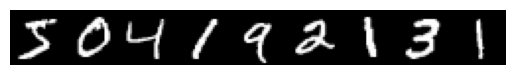

In [ ]:
# Loading Mnist dataset
mnist_data = mnist.load_data()

#loading of dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()


print('Display of Train and Test sample size:\n')
print('\n-------------->\n')

#shape of dataset
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

print('\n-------------->\n')

# Update to horizontal stacking
stacked_images = np.hstack([train_X[i] for i in range(9)])

# Display the stacked images
plt.imshow(stacked_images, cmap='gray')
plt.axis('off')  # Remove axes for a clean display
plt.show()



In [ ]:
# Check Cuda Compatability
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. Using CPU.")

GPU is available!
Using GPU: Tesla T4


In [ ]:
# Tranformations in dataset
transform_data= transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])


In [ ]:
# Load MNIST dataset with training and test splits
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_data)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_data)

# use dataloader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
print(train_dataset)
print('\n----------->\n')
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], scale=(0.8, 1.2))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

----------->

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], scale=(0.8, 1.2))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


**Define MLP Model Architecture**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

        # Custom weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten image
        x = torch.relu(self.fc1(x))
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [ ]:
# Intialize the loss Function and optimizer
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Model Training**

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        Total_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Back pass
            optimizer.zero_grad()
            loss.backward()

            # Update grads
            optimizer.step()

            # loss during each epoch
            Total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {Total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")


**Model Evaluation**

In [ ]:
def evaluate_model(model, test_loader):
   #set to evaluation mode
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad(): # no calculation of gradients during testing
        for inputs,labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.append(predicted.numpy())
            all_labels.append(labels.numpy())

    return all_labels, all_preds


In [ ]:
def report_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)

    # plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [ ]:
train_model(model, train_loader, criterion, optimizer, epochs=10)
y_true, y_pred = evaluate_model(model, test_loader)



Epoch 1/10, Loss: 0.6008, Accuracy: 81.26%
Epoch 2/10, Loss: 0.4225, Accuracy: 86.98%
Epoch 3/10, Loss: 0.3693, Accuracy: 88.55%
Epoch 4/10, Loss: 0.3510, Accuracy: 89.19%
Epoch 5/10, Loss: 0.3389, Accuracy: 89.51%
Epoch 6/10, Loss: 0.3250, Accuracy: 89.86%
Epoch 7/10, Loss: 0.3218, Accuracy: 89.94%
Epoch 8/10, Loss: 0.3164, Accuracy: 90.12%
Epoch 9/10, Loss: 0.3057, Accuracy: 90.49%
Epoch 10/10, Loss: 0.2950, Accuracy: 90.83%


Precision: 0.9480
Recall: 0.9476
F1-score: 0.9476


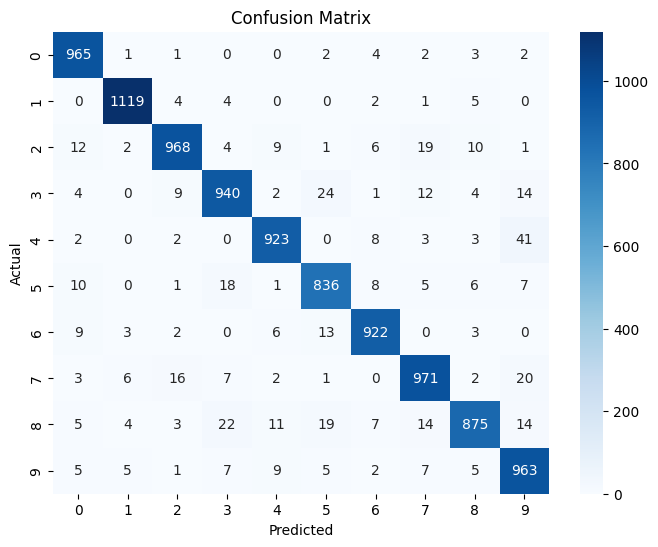

In [ ]:
# Flatten y_true and y_pred
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

report_metrics(y_true, y_pred)

**Hyperprameter Tuning**

In [ ]:
# Define a function for hyperparameter tuning
def hyperparameter_tuning(train_loader, param_grid):
    best_model = None
    best_accuracy = 0
    best_params = None

    for params in ParameterGrid(param_grid):
        # Initialize the model, loss function, and optimizer
        model = MLP(input_size=28*28, hidden_size=params['hidden_size'], output_size=10)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])

        # Train the model
        train_model(model, train_loader, criterion, optimizer, params['epochs'])

        # Evaluate the model
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in train_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Params: {params}, Accuracy: {accuracy:.2f}%")

        # Save the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_params = params

    print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy:.2f}%")
    return best_model, best_params

